In [23]:
# Tony Smoragiewicz
# EECE 5639 - Project 1
# Northeastern - Fall 2021

from matplotlib import pyplot as plt
import cv2
import numpy as np
import os

In [24]:
# Define loader and converter
def load_images_from_folder(folder):
    images = []
    for filename in sorted(os.listdir(folder)):
        img = cv2.imread(os.path.join(folder,filename))
        if img is not None:
            gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            images.append(gray)
    return images


In [25]:
# Load the images and convert to grayscale
img_dir = "/home/tsmorz/Documents/Education/Northeastern/EECE 5639 - Computer Vision/Projects/RedChair" # Enter Directory of all images  
images  = load_images_from_folder(img_dir);
images = np.array(images);
idx, r, c = images.shape;
print(images.shape);

(353, 240, 320)


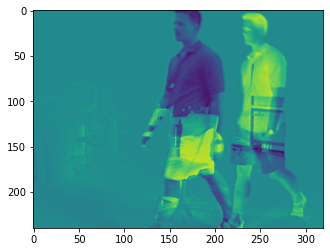

In [26]:
# Temporal filter
temporal_filter = 0.5*np.array([-1.,0.,1.])

frame = 215
frames = [images[frame-1,:,:],images[frame,:,:],images[frame+1,:,:]]
im_mask = np.tensordot(temporal_filter,frames,axes=(0,0))

plt.imshow(im_mask)
plt.show()

In [27]:
# Gaussian filter
gaussian_filter = np.array([0.011, 0.135, 0.606, 0.135, 0.011])
gaussian_filter = gaussian_filter/np.sum(gaussian_filter)
print(gaussian_filter)

frame = 215
frames = [images[frame-3,:,:],images[frame-2,:,:],images[frame-1,:,:],images[frame,:,:],images[frame+1,:,:],images[frame+2,:,:],images[frame+3,:,:]]
im_mask = np.tensordot(gaussian_filter,frames,axes=(0,0))

plt.imshow(im_mask)
plt.show()

[0.01224944 0.15033408 0.67483296 0.15033408 0.01224944]


ValueError: shape-mismatch for sum

In [ ]:
# Spatial median filter
denoise = np.zeros((idx-1, r, c))
for i in range(idx-1):
    #denoise[i,:,:] = cv2.filter2D(src=images[i,:,:], ddepth=-1, kernel=gaussian)
    denoise[i,:,:] = cv2.medianBlur(images[i,:,:], 3)

In [ ]:
# Temporal median filter
temp_median = np.zeros((idx-1, r, c))
for i in range(idx-5):
    median5 = [denoise[i,:,:], denoise[i+1,:,:], denoise[i+2,:,:], denoise[i+3,:,:], denoise[i+4,:,:]]
    median5 = np.array(median5)
    median5 = np.median(median5,axis=0)
    temp_median[i,:,:] = median5

91


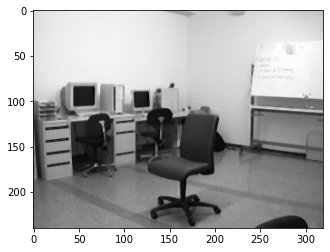

In [ ]:
plt.subplot()
im = np.random.randint(idx)
plt.imshow(temp_median[im,:,:], cmap='gray')
print(im)

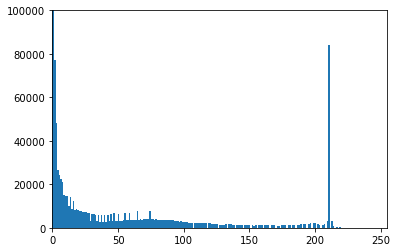

In [ ]:
# Temporal gradient
motion = np.zeros((idx-1, r, c))
for i in range(idx-1):
    temp_grad = denoise[i,:,:] - temp_median[i-1,:,:]
    #temp_grad = 0.5*(denoise[i+1,:,:] - denoise[i-1,:,:])
    motion[i,:,:] = np.abs(temp_grad)
    motion[i,:,:] = temp_grad**2/255
noise_line  = np.reshape(motion, ((idx-1)*r*c, 1) )

plt.subplot()
plt.hist(noise_line, bins=200);
plt.ylim([0,100000]);
plt.xlim([0,255]);

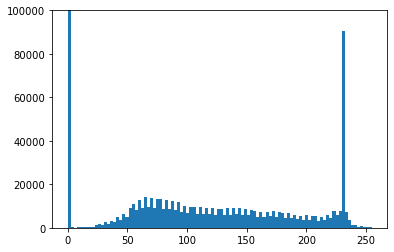

In [ ]:
# Apply a threshold
mask = np.zeros((idx-1, r, c))
threshold = 5
for i in range(idx-1):
    mask[i] = (motion[i,:,:] > threshold)*images[i,:,:]
mask_line  = np.reshape(mask, ((idx-1)*r*c, 1) )

plt.subplot()
plt.hist(mask_line, bins=100);
plt.ylim([0,100000]);

188
3.768627450980392


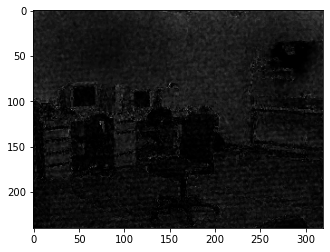

In [ ]:
# Tough Images
plt.subplot()
im = 188
plt.imshow(motion[im,:,:], cmap='gray')
print(im)
print(np.amax(motion[im,:,:]))

62
247.0


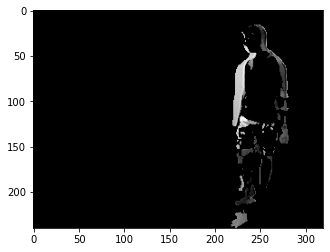

In [ ]:
plt.subplot()
im = np.random.randint(idx)
im = 62
plt.imshow(mask[im,:,:], cmap='gray')
print(im)
print(np.amax(mask[im,:,:]))

62


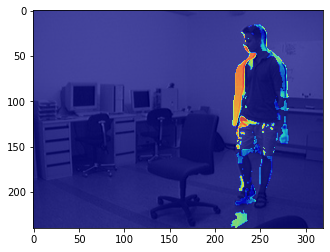

In [ ]:
im = np.random.randint(idx)
im = 62
print(im)
plt.subplot()
plt.imshow(images[im,:,:], cmap='gray')
plt.imshow(mask[im,:,:], cmap='jet', alpha=0.7)